<a href="https://colab.research.google.com/github/kikifana/Team_1_WeLead/blob/main/D02_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
import os

# Define a directory to save plots
plot_dir = "model_plots"
os.makedirs(plot_dir, exist_ok=True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
xlsx_path = '/content/drive/MyDrive/mpg.data.xlsx'
csv_path = '/content/drive/MyDrive/mpg_data.csv'

df = pd.read_excel(xlsx_path, engine='openpyxl')

df.to_csv(csv_path, index=False)

print(f"CSV file saved at: {csv_path}")

CSV file saved at: /content/drive/MyDrive/mpg_data.csv


Drop empty columns: Unnamed: 9 - Unnamed: 12
Drop NaNs from mpg and horsepower columns. There are very few NaNs so dropping them will not be a problem.

In [ ]:
df = df.drop(columns=['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'], errors='ignore')
df = df.dropna(subset=['mpg', 'horsepower'])

Clean the car name column and extract brand names, then get the known brands so we can check for misspelled words. We then extract the brand name and also keep two-word brands such as Mercedes-Benz. We define the brand corrections for misspellings and abbreviations

In [ ]:
df['car name'] = df['car name'].str.replace(r'\s+', ' ', regex=True).str.strip()

known_brands = ["mercedes benz", "chevrolet", "ford", "buick", "plymouth",
    "volkswagen", "peugeot", "audi", "saab", "bmw", "toyota", "mazda", "pontiac",
    "mercury", "nissan", "honda", "subaru", "chrysler", "dodge", "fiat", "opel", "renault"]

def extract_brand(name):
    words = name.split()
    two_word_brand = " ".join(words[:2]).lower()
    if two_word_brand in known_brands:
        return two_word_brand
    return words[0].lower()

df['car_name_merge'] = df['car name'].apply(extract_brand)

# Define brand corrections
brand_corrections = {
    "mercedes": "mercedes-benz",
    "vw": "volkswagen",
    "chevy": "chevrolet",
    "toyouta": "toyota",
    "chevroelt": "chevrolet",
    "maxda": "mazda",
    "vokswagen": "volkswagen",
    "capri": "mercury",
    "datsun": "nissan"
}

df["car_name_merge"] = df["car_name_merge"].replace(brand_corrections)

# Drop "car name" column since it's not needed anymore
df = df.drop(columns=["car name"])




In [ ]:
df = df[df["car_name_merge"] != "hi"]
print("hi 1200d' entry has been successfully removed.")

hi 1200d' entry has been successfully removed.


In [ ]:
print(df["car_name_merge"].value_counts())

car_name_merge
ford             48
chevrolet        47
plymouth         31
dodge            28
amc              27
toyota           26
nissan           24
volkswagen       22
buick            17
pontiac          16
honda            13
mazda            12
mercury          12
oldsmobile       10
fiat              8
peugeot           8
audi              7
chrysler          6
volvo             6
saab              4
opel              4
subaru            4
renault           3
bmw               2
mercedes-benz     2
cadillac          2
mercedes benz     1
triumph           1
Name: count, dtype: int64


We continue our analysis with two different ways.
1. Calculating manually MPG clusters based on observations of the mpg's histogram.
2. KMeans Clustering. We looped from 2 to 5 and found the elbow in k = 3

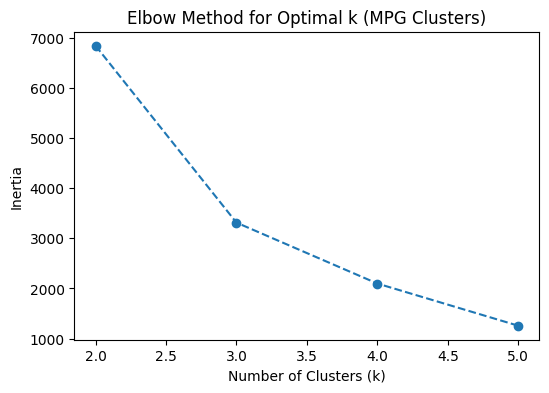

In [ ]:
# Manual MPG Clustering --- based on the histogram of mpg
bins = [0, 20, 30, max(df['mpg'].max(), 50)]
labels = ['Low', 'Medium', 'High']
df['mpg_cluster'] = pd.cut(df['mpg'], bins=bins, labels=labels)

# KMeans Clustering - Find best k using Elbow Method
inertia = []
K_range = range(2, 6)  # Testing k from 2 to 5

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df[['mpg']])
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker='o', linestyle='dashed')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (MPG Clusters)')
plt.show()

# Select optimal k manually
optimal_k = 3
df['mpg_kmeans'] = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit_predict(df[['mpg']])
df = df.drop(columns=['mpg'])  # Drop actual MPG after clustering


The function preprocess_features:
1. Choose between standard scaling or min max scaling
2. Apply One Hot Encoding to car_name_merge, cylinders, origin columns
3. Apply the chosen scaler in the rest features that are not one hot encoded.


In [ ]:
def preprocess_features(df, scale_method="standard"):

    categorical_columns = ["car_name_merge", "cylinders", "origin"]
    existing_categoricals = [col for col in categorical_columns if col in df.columns]

    if existing_categoricals:
        df = pd.get_dummies(df, columns=existing_categoricals, drop_first=True)

    num_features = ['displayments', 'horsepower', 'weight', 'acceleration', 'model year']
    existing_num_features = [col for col in num_features if col in df.columns]

    # Choose Standard or MinMax Scaler
    if scale_method == "standard":
        scaler = StandardScaler()
    elif scale_method == "minmax":
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scale_method. Choose 'standard' or 'minmax'.")

    if existing_num_features:
        df[existing_num_features] = scaler.fit_transform(df[existing_num_features])

    return df





In [ ]:
# Standard Scaled Dataset
df_standard_scaled = preprocess_features(df.copy(), scale_method="standard")

# Min-Max Scaled Dataset
df_minmax_scaled = preprocess_features(df.copy(), scale_method="minmax")



We split the two datasets (min-max dataset and standard dataset) using train_test_split().

In [ ]:
# Splitting Standard Scaled Data
X_standard = df_standard_scaled.drop(columns=['mpg_cluster', 'mpg_kmeans'])
y_manual_standard = df_standard_scaled['mpg_cluster']
y_kmeans_standard = df_standard_scaled['mpg_kmeans']

X_train_manual_std, X_test_manual_std, y_train_manual_std, y_test_manual_std = train_test_split(
    X_standard, y_manual_standard, test_size=0.2, random_state=42, stratify=y_manual_standard
)
X_train_kmeans_std, X_test_kmeans_std, y_train_kmeans_std, y_test_kmeans_std = train_test_split(
    X_standard, y_kmeans_standard, test_size=0.2, random_state=42, stratify=y_kmeans_standard
)

# Splitting MinMax Scaled Data
X_minmax = df_minmax_scaled.drop(columns=['mpg_cluster', 'mpg_kmeans'])
y_manual_minmax = df_minmax_scaled['mpg_cluster']
y_kmeans_minmax = df_minmax_scaled['mpg_kmeans']

X_train_manual_mm, X_test_manual_mm, y_train_manual_mm, y_test_manual_mm = train_test_split(
    X_minmax, y_manual_minmax, test_size=0.2, random_state=42, stratify=y_manual_minmax
)
X_train_kmeans_mm, X_test_kmeans_mm, y_train_kmeans_mm, y_test_kmeans_mm = train_test_split(
    X_minmax, y_kmeans_minmax, test_size=0.2, random_state=42, stratify=y_kmeans_minmax
)


The function evaluate_and_plot_model():
1. Train (fit) the model
2. Predict
3. Compute classification metrics (accuracy, precision, recall, f1_score)
4. Compute and plot the confusion matrix

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
import os

# Create directory for saving plots if it doesn't exist
plot_dir = "classification_results"
os.makedirs(plot_dir, exist_ok=True)

def evaluate_and_plot_model(model, X_train, X_test, y_train, y_test, dataset_type):

    print(f"\n Training {model.__class__.__name__} on {dataset_type}...")
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average="weighted")
    recall = recall_score(y_test, y_pred_test, average="weighted")
    f1 = f1_score(y_test, y_pred_test, average="weighted")


    print(f"\n {model.__class__.__name__} Performance ({dataset_type}):")
    print(f" Accuracy:  {accuracy:.4f}")
    print(f" Precision: {precision:.4f}")
    print(f" Recall:    {recall:.4f}")
    print(f" F1 Score:  {f1:.4f}")


    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))


    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues", values_format=".0f")
    plt.title(f"Confusion Matrix - {model.__class__.__name__} ({dataset_type})")


    cm_path = os.path.join(plot_dir, f"confusion_matrix_{model.__class__.__name__}_{dataset_type}.png")
    plt.savefig(cm_path, dpi=300)
    print(f" Confusion matrix saved: {cm_path}")

    plt.show()


    return {
        "Model": model.__class__.__name__,
        "Dataset": dataset_type,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }



Define the 5 models we tested.
1. Random Forest Classifier
2. SVM
3. MLP
4. KNN
5. Logistic Regression

We stored the results in results and we looped through the datasets for training and testing.


 Training RandomForestClassifier on Manual Clustering (Standard)...

 RandomForestClassifier Performance (Manual Clustering (Standard)):
 Accuracy:  0.7975
 Precision: 0.7988
 Recall:    0.7975
 F1 Score:  0.7953
 Confusion matrix saved: classification_results/confusion_matrix_RandomForestClassifier_Manual Clustering (Standard).png


<Figure size 600x600 with 0 Axes>

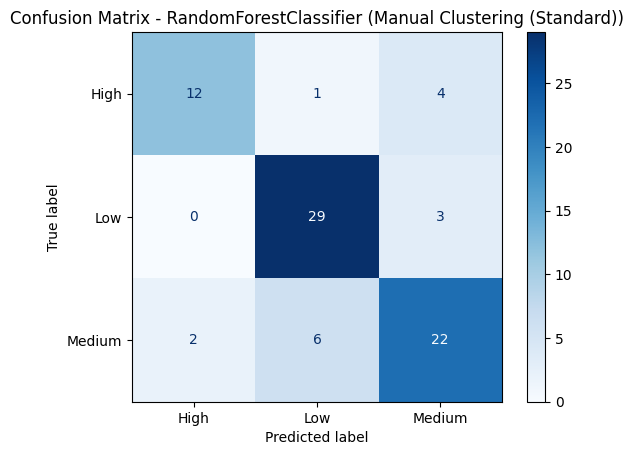


 Training RandomForestClassifier on KMeans Clustering (Standard)...

 RandomForestClassifier Performance (KMeans Clustering (Standard)):
 Accuracy:  0.8354
 Precision: 0.8339
 Recall:    0.8354
 F1 Score:  0.8318
 Confusion matrix saved: classification_results/confusion_matrix_RandomForestClassifier_KMeans Clustering (Standard).png


<Figure size 600x600 with 0 Axes>

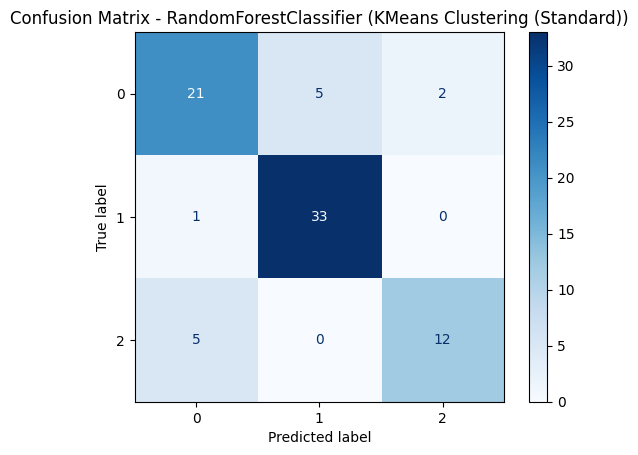


 Training RandomForestClassifier on Manual Clustering (MinMax)...

 RandomForestClassifier Performance (Manual Clustering (MinMax)):
 Accuracy:  0.7975
 Precision: 0.7988
 Recall:    0.7975
 F1 Score:  0.7953
 Confusion matrix saved: classification_results/confusion_matrix_RandomForestClassifier_Manual Clustering (MinMax).png


<Figure size 600x600 with 0 Axes>

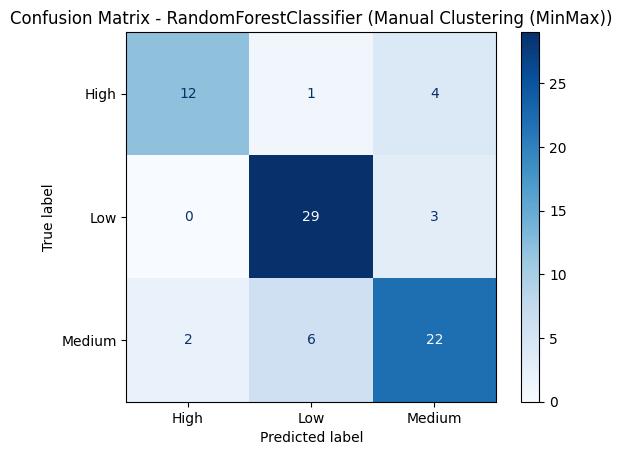


 Training RandomForestClassifier on KMeans Clustering (MinMax)...

 RandomForestClassifier Performance (KMeans Clustering (MinMax)):
 Accuracy:  0.8354
 Precision: 0.8339
 Recall:    0.8354
 F1 Score:  0.8318
 Confusion matrix saved: classification_results/confusion_matrix_RandomForestClassifier_KMeans Clustering (MinMax).png


<Figure size 600x600 with 0 Axes>

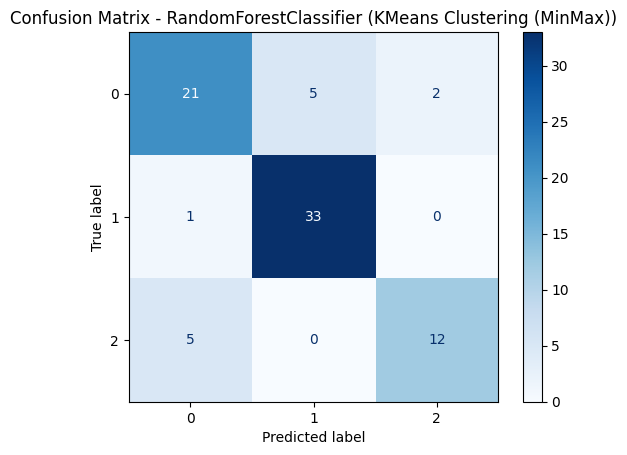


 Training SVC on Manual Clustering (Standard)...

 SVC Performance (Manual Clustering (Standard)):
 Accuracy:  0.8101
 Precision: 0.8289
 Recall:    0.8101
 F1 Score:  0.8061
 Confusion matrix saved: classification_results/confusion_matrix_SVC_Manual Clustering (Standard).png


<Figure size 600x600 with 0 Axes>

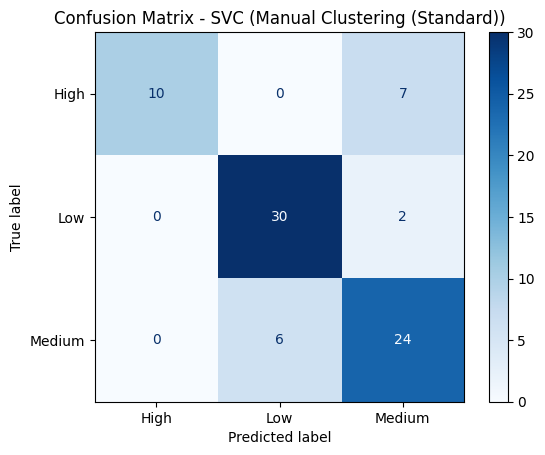


 Training SVC on KMeans Clustering (Standard)...

 SVC Performance (KMeans Clustering (Standard)):
 Accuracy:  0.7595
 Precision: 0.7599
 Recall:    0.7595
 F1 Score:  0.7526
 Confusion matrix saved: classification_results/confusion_matrix_SVC_KMeans Clustering (Standard).png


<Figure size 600x600 with 0 Axes>

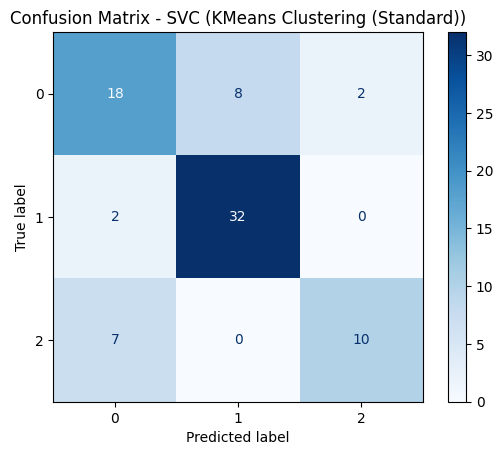


 Training SVC on Manual Clustering (MinMax)...

 SVC Performance (Manual Clustering (MinMax)):
 Accuracy:  0.6582
 Precision: 0.5180
 Recall:    0.6582
 F1 Score:  0.5797


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Confusion matrix saved: classification_results/confusion_matrix_SVC_Manual Clustering (MinMax).png


<Figure size 600x600 with 0 Axes>

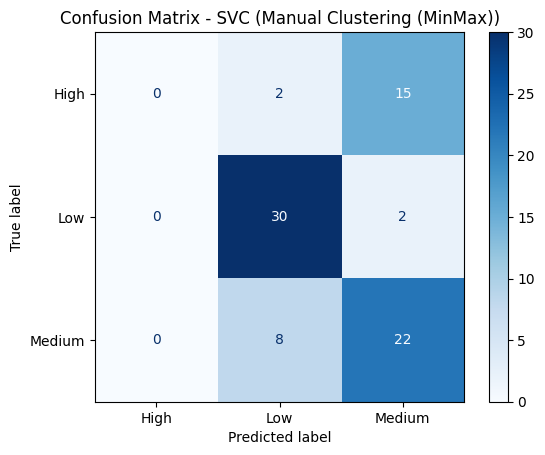


 Training SVC on KMeans Clustering (MinMax)...

 SVC Performance (KMeans Clustering (MinMax)):
 Accuracy:  0.6582
 Precision: 0.5261
 Recall:    0.6582
 F1 Score:  0.5838


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Confusion matrix saved: classification_results/confusion_matrix_SVC_KMeans Clustering (MinMax).png


<Figure size 600x600 with 0 Axes>

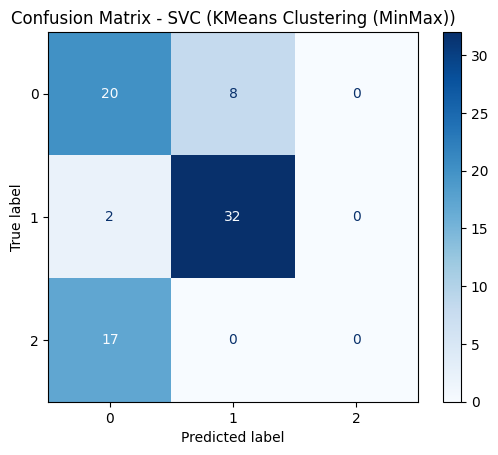


 Training MLPClassifier on Manual Clustering (Standard)...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(



 MLPClassifier Performance (Manual Clustering (Standard)):
 Accuracy:  0.7342
 Precision: 0.7322
 Recall:    0.7342
 F1 Score:  0.7224
 Confusion matrix saved: classification_results/confusion_matrix_MLPClassifier_Manual Clustering (Standard).png


<Figure size 600x600 with 0 Axes>

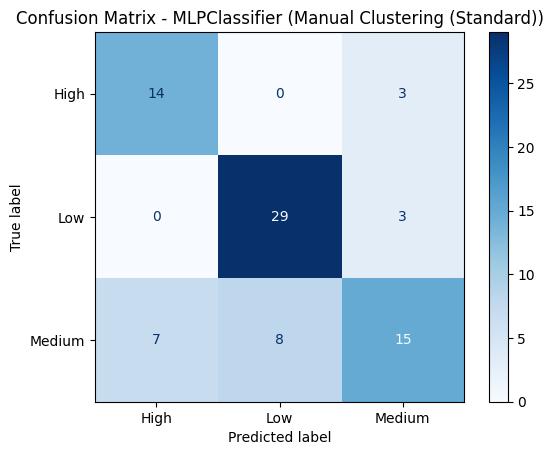


 Training MLPClassifier on KMeans Clustering (Standard)...

 MLPClassifier Performance (KMeans Clustering (Standard)):
 Accuracy:  0.7468
 Precision: 0.7406
 Recall:    0.7468
 F1 Score:  0.7413
 Confusion matrix saved: classification_results/confusion_matrix_MLPClassifier_KMeans Clustering (Standard).png


<Figure size 600x600 with 0 Axes>

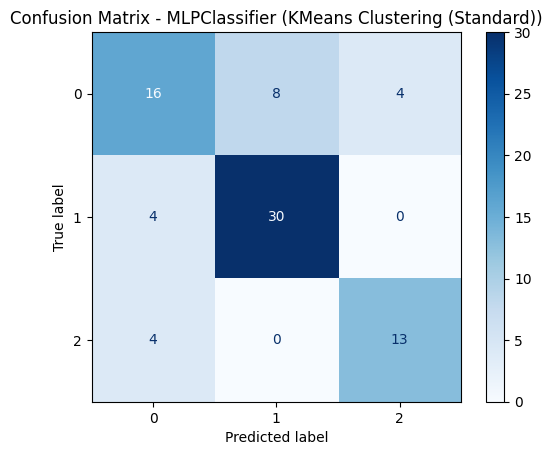


 Training MLPClassifier on Manual Clustering (MinMax)...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(



 MLPClassifier Performance (Manual Clustering (MinMax)):
 Accuracy:  0.7215
 Precision: 0.7162
 Recall:    0.7215
 F1 Score:  0.7136
 Confusion matrix saved: classification_results/confusion_matrix_MLPClassifier_Manual Clustering (MinMax).png


<Figure size 600x600 with 0 Axes>

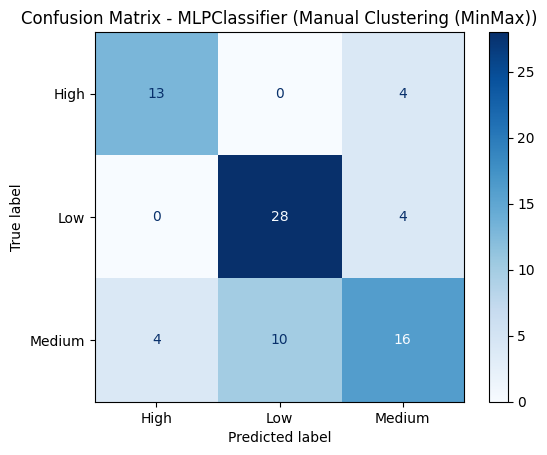


 Training MLPClassifier on KMeans Clustering (MinMax)...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(



 MLPClassifier Performance (KMeans Clustering (MinMax)):
 Accuracy:  0.7215
 Precision: 0.7260
 Recall:    0.7215
 F1 Score:  0.7220
 Confusion matrix saved: classification_results/confusion_matrix_MLPClassifier_KMeans Clustering (MinMax).png


<Figure size 600x600 with 0 Axes>

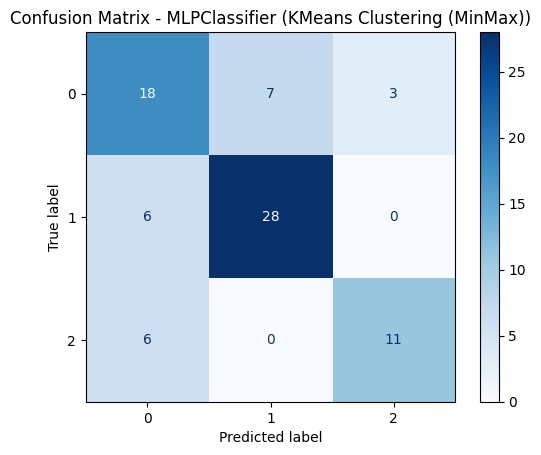


 Training KNeighborsClassifier on Manual Clustering (Standard)...

 KNeighborsClassifier Performance (Manual Clustering (Standard)):
 Accuracy:  0.7722
 Precision: 0.7687
 Recall:    0.7722
 F1 Score:  0.7652
 Confusion matrix saved: classification_results/confusion_matrix_KNeighborsClassifier_Manual Clustering (Standard).png


<Figure size 600x600 with 0 Axes>

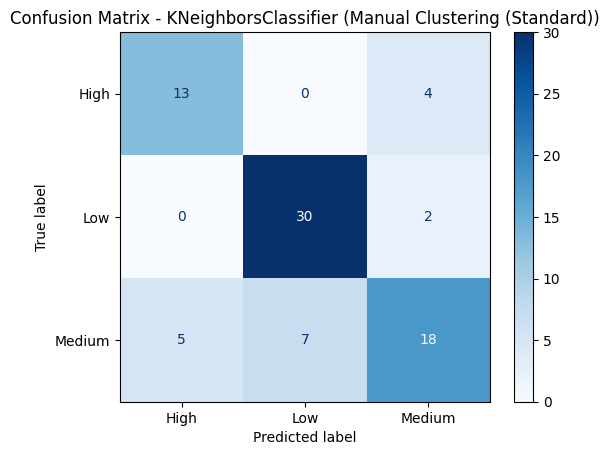


 Training KNeighborsClassifier on KMeans Clustering (Standard)...

 KNeighborsClassifier Performance (KMeans Clustering (Standard)):
 Accuracy:  0.7975
 Precision: 0.7959
 Recall:    0.7975
 F1 Score:  0.7958
 Confusion matrix saved: classification_results/confusion_matrix_KNeighborsClassifier_KMeans Clustering (Standard).png


<Figure size 600x600 with 0 Axes>

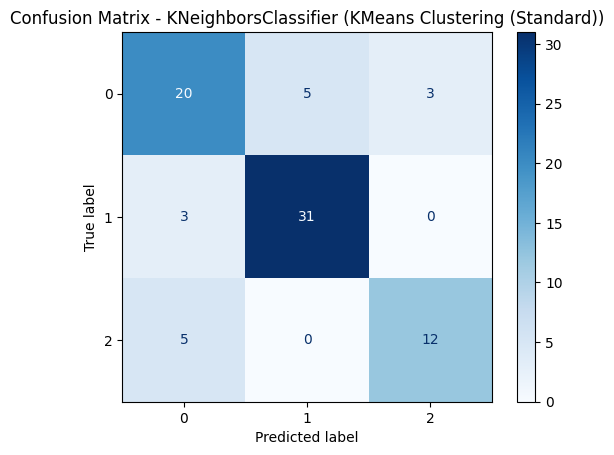


 Training KNeighborsClassifier on Manual Clustering (MinMax)...

 KNeighborsClassifier Performance (Manual Clustering (MinMax)):
 Accuracy:  0.7595
 Precision: 0.7602
 Recall:    0.7595
 F1 Score:  0.7530
 Confusion matrix saved: classification_results/confusion_matrix_KNeighborsClassifier_Manual Clustering (MinMax).png


<Figure size 600x600 with 0 Axes>

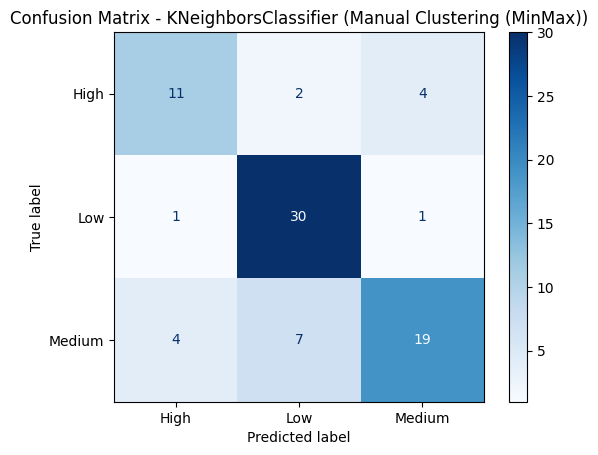


 Training KNeighborsClassifier on KMeans Clustering (MinMax)...

 KNeighborsClassifier Performance (KMeans Clustering (MinMax)):
 Accuracy:  0.7595
 Precision: 0.7542
 Recall:    0.7595
 F1 Score:  0.7520
 Confusion matrix saved: classification_results/confusion_matrix_KNeighborsClassifier_KMeans Clustering (MinMax).png


<Figure size 600x600 with 0 Axes>

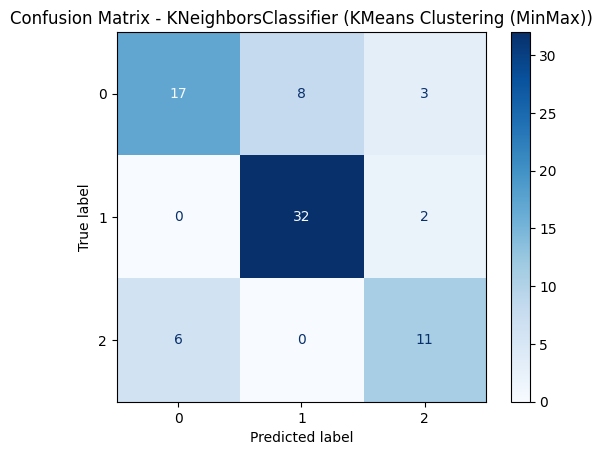


 Training LogisticRegression on Manual Clustering (Standard)...

 LogisticRegression Performance (Manual Clustering (Standard)):
 Accuracy:  0.7342
 Precision: 0.7287
 Recall:    0.7342
 F1 Score:  0.7269
 Confusion matrix saved: classification_results/confusion_matrix_LogisticRegression_Manual Clustering (Standard).png


<Figure size 600x600 with 0 Axes>

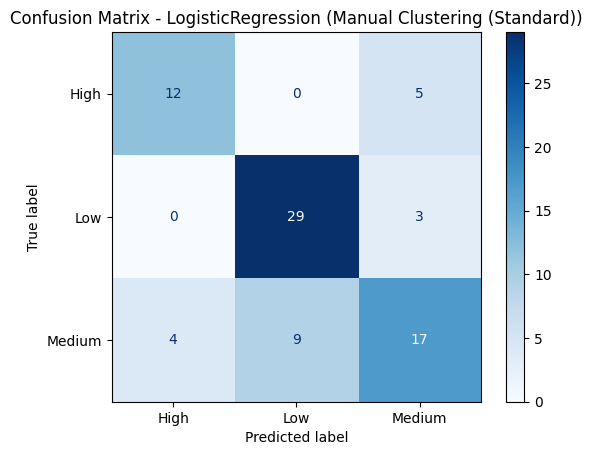


 Training LogisticRegression on KMeans Clustering (Standard)...

 LogisticRegression Performance (KMeans Clustering (Standard)):
 Accuracy:  0.7975
 Precision: 0.7959
 Recall:    0.7975
 F1 Score:  0.7958
 Confusion matrix saved: classification_results/confusion_matrix_LogisticRegression_KMeans Clustering (Standard).png


<Figure size 600x600 with 0 Axes>

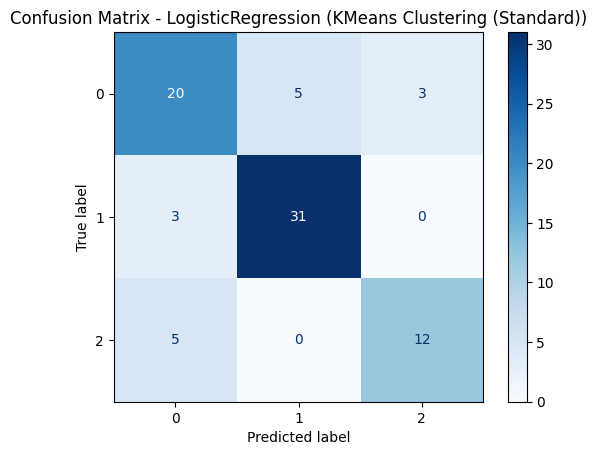


 Training LogisticRegression on Manual Clustering (MinMax)...

 LogisticRegression Performance (Manual Clustering (MinMax)):
 Accuracy:  0.7595
 Precision: 0.7608
 Recall:    0.7595
 F1 Score:  0.7521
 Confusion matrix saved: classification_results/confusion_matrix_LogisticRegression_Manual Clustering (MinMax).png


<Figure size 600x600 with 0 Axes>

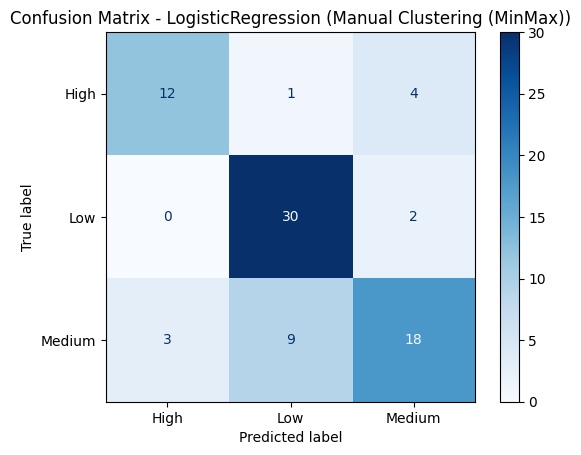


 Training LogisticRegression on KMeans Clustering (MinMax)...

 LogisticRegression Performance (KMeans Clustering (MinMax)):
 Accuracy:  0.7975
 Precision: 0.7962
 Recall:    0.7975
 F1 Score:  0.7911
 Confusion matrix saved: classification_results/confusion_matrix_LogisticRegression_KMeans Clustering (MinMax).png


<Figure size 600x600 with 0 Axes>

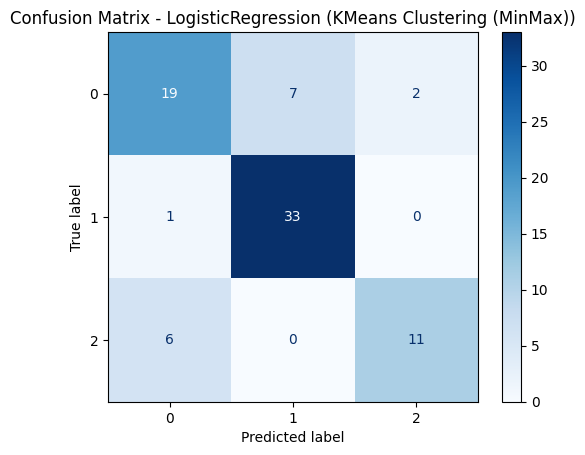

                     Model                       Dataset  Accuracy  Precision  \
0   RandomForestClassifier  Manual Clustering (Standard)  0.797468   0.798833   
1   RandomForestClassifier  KMeans Clustering (Standard)  0.835443   0.833867   
2   RandomForestClassifier    Manual Clustering (MinMax)  0.797468   0.798833   
3   RandomForestClassifier    KMeans Clustering (MinMax)  0.835443   0.833867   
4                      SVC  Manual Clustering (Standard)  0.810127   0.828922   
5                      SVC  KMeans Clustering (Standard)  0.759494   0.759916   
6                      SVC    Manual Clustering (MinMax)  0.658228   0.518014   
7                      SVC    KMeans Clustering (MinMax)  0.658228   0.526063   
8            MLPClassifier  Manual Clustering (Standard)  0.734177   0.732190   
9            MLPClassifier  KMeans Clustering (Standard)  0.746835   0.740617   
10           MLPClassifier    Manual Clustering (MinMax)  0.721519   0.716189   
11           MLPClassifier  

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(C=1, gamma=0.01, kernel='rbf', probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=600, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LogReg": LogisticRegression(max_iter=200, random_state=42)
}
results = []
datasets = {
    "Manual Clustering (Standard)": (X_train_manual_std, X_test_manual_std, y_train_manual_std, y_test_manual_std),
    "KMeans Clustering (Standard)": (X_train_kmeans_std, X_test_kmeans_std, y_train_kmeans_std, y_test_kmeans_std),
    "Manual Clustering (MinMax)": (X_train_manual_mm, X_test_manual_mm, y_train_manual_mm, y_test_manual_mm),
    "KMeans Clustering (MinMax)": (X_train_kmeans_mm, X_test_kmeans_mm, y_train_kmeans_mm, y_test_kmeans_mm)
}


for name, model in models.items():
    for dataset_type, (X_train, X_test, y_train, y_test) in datasets.items():
        result = evaluate_and_plot_model(model, X_train, X_test, y_train, y_test, dataset_type)
        results.append(result)


results_df = pd.DataFrame(results)
print(results_df)




Initial Display of Results
1. KMeans generally improved performance for most models, especially for RandomForestClassifier and LogisticRegression.
2. Standard scaling performed better overall, especially for SVC, KNeighborsClassifier, and LogisticRegression.

In [ ]:
display(results_df)

,Model,Dataset,Accuracy,Precision,Recall,F1 Score
0,RandomForestClassifier,Manual Clustering (Standard),0.797468,0.798833,0.797468,0.795295
1,RandomForestClassifier,KMeans Clustering (Standard),0.835443,0.833867,0.835443,0.831769
2,RandomForestClassifier,Manual Clustering (MinMax),0.797468,0.798833,0.797468,0.795295
3,RandomForestClassifier,KMeans Clustering (MinMax),0.835443,0.833867,0.835443,0.831769
4,SVC,Manual Clustering (Standard),0.810127,0.828922,0.810127,0.806140
5,SVC,KMeans Clustering (Standard),0.759494,0.759916,0.759494,0.752618
6,SVC,Manual Clustering (MinMax),0.658228,0.518014,0.658228,0.579710
7,SVC,KMeans Clustering (MinMax),0.658228,0.526063,0.658228,0.583821
8,MLPClassifier,Manual Clustering (Standard),0.734177,0.732190,0.734177,0.722429
9,MLPClassifier,KMeans Clustering (Standard),0.746835,0.740617,0.746835,0.741318


Based on the previous results we picked kmeans clusters with standard scaling as it perfomed the best. We performed cross validation to avoid overfitting next.
Random Forest should be kept as it achieved the highest cross-validation accuracy (85.22%), precision (85.49%), recall (85.22%), and F1-score (85.13%), making it the most robust and reliable model for prediction.

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
X = X_train_kmeans_std
y = y_train_kmeans_std

def evaluate_models_with_cv(models, X, y, cv_folds=5):

    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    results = []

    for name, model in models.items():
        print(f"\n Evaluating {name} with {cv_folds}-fold Cross-Validation...")
        accuracy = cross_val_score(model, X, y, cv=skf, scoring='accuracy').mean()
        precision = cross_val_score(model, X, y, cv=skf, scoring='precision_weighted').mean()
        recall = cross_val_score(model, X, y, cv=skf, scoring='recall_weighted').mean()
        f1 = cross_val_score(model, X, y, cv=skf, scoring='f1_weighted').mean()

        print(f" {name} Performance (Cross-Validation):")
        print(f" Accuracy:  {accuracy:.4f}")
        print(f" Precision: {precision:.4f}")
        print(f" Recall:    {recall:.4f}")
        print(f" F1 Score:  {f1:.4f}")

        results.append({
            "Model": name,
            "CV Accuracy": accuracy,
            "CV Precision": precision,
            "CV Recall": recall,
            "CV F1 Score": f1
        })

    return pd.DataFrame(results)

cv_results = evaluate_models_with_cv(models, X, y, cv_folds=5)

cv_results_df = pd.DataFrame(cv_results)
display(cv_results_df)



 Evaluating RandomForest with 5-fold Cross-Validation...
 RandomForest Performance (Cross-Validation):
 Accuracy:  0.8522
 Precision: 0.8549
 Recall:    0.8522
 F1 Score:  0.8513

 Evaluating SVM with 5-fold Cross-Validation...
 SVM Performance (Cross-Validation):
 Accuracy:  0.8267
 Precision: 0.8357
 Recall:    0.8267
 F1 Score:  0.8226

 Evaluating MLP with 5-fold Cross-Validation...
 MLP Performance (Cross-Validation):
 Accuracy:  0.8363
 Precision: 0.8394
 Recall:    0.8363
 F1 Score:  0.8357

 Evaluating KNN with 5-fold Cross-Validation...
 KNN Performance (Cross-Validation):
 Accuracy:  0.8235
 Precision: 0.8241
 Recall:    0.8235
 F1 Score:  0.8222

 Evaluating LogReg with 5-fold Cross-Validation...
 LogReg Performance (Cross-Validation):
 Accuracy:  0.8459
 Precision: 0.8516
 Recall:    0.8459
 F1 Score:  0.8464


,Model,CV Accuracy,CV Precision,CV Recall,CV F1 Score
0,RandomForest,0.852227,0.854891,0.852227,0.851319
1,SVM,0.826677,0.835678,0.826677,0.822590
2,MLP,0.836303,0.839450,0.836303,0.835661
3,KNN,0.823502,0.824133,0.823502,0.822214
4,LogReg,0.845878,0.851615,0.845878,0.846371


We check also with a simple Random Forest to get the top 5 features.

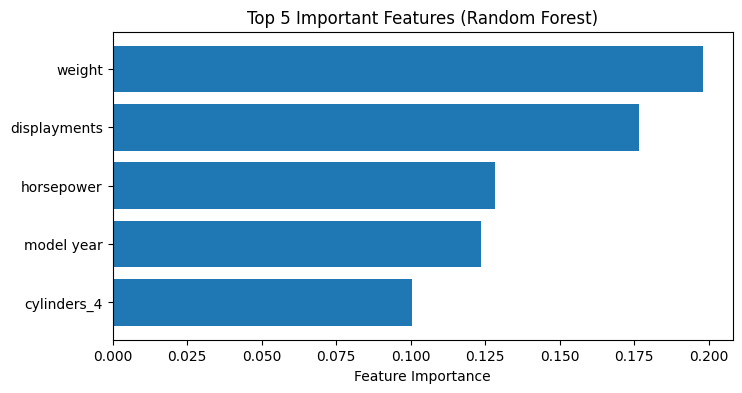

Selected Top 5 Features: ['weight', 'displayments', 'horsepower', 'model year', 'cylinders_4']


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

rf_selector = RandomForestClassifier(n_estimators=200, random_state=42)
rf_selector.fit(X_train_kmeans_std, y_train_kmeans_std)
feature_importance = rf_selector.feature_importances_
features = X_train_kmeans_std.columns
sorted_idx = np.argsort(feature_importance)[::-1]
top_features = [features[i] for i in sorted_idx[:5]]

plt.figure(figsize=(8, 4))
plt.barh(np.array(features)[sorted_idx][:5], feature_importance[sorted_idx][:5])
plt.xlabel("Feature Importance")
plt.title("Top 5 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

print(f"Selected Top 5 Features: {top_features}")

We train and test the Random Forest classifier with only these top 5 feautes. The accuracy of Random Forest with the top 5 features is lower than the full feature set.
While feature selection can improve the accuracy, it may not be beneficial as the model performs better with the full feature set as it is a small relatively dataset.

In [ ]:
# Select top 5 features
X_top5 = X_train_kmeans_std[top_features]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_top5 = RandomForestClassifier(n_estimators=200, random_state=42)
accuracy_scores = cross_val_score(rf_top5, X_top5, y_train_kmeans_std, cv=cv, scoring='accuracy')
print(f"Random Forest Accuracy with Top 5 Features (Cross-Validation): {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")

Random Forest Accuracy with Top 5 Features (Cross-Validation): 0.8331 ± 0.0587
